# Time Frequency Analysis of Neural Signals

In [185]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as sio

## Defining required functions

### Taking average signal from all trials

In [186]:
def avg_trial(data):
    data = np.array(data)
    data = np.mean(data, axis=0)
    return data

### Plotting all trials

In [187]:
# plotting all trials
def plot_trails(wave,time):
    plt.figure(figsize=(25,10))
    for i in range(0,len(wave)):
        plt.plot(time, wave[i])
    plt.show()

### Computing FFT and Power spectra

In [188]:
def compute_spectra(wave,fs,time):
    # gives DFT sample frequencies
    freqs = np.fft.fftfreq(time.size, 1/fs)

    # ignoring half the values( all negative values of freqs) since they are complex conjugate of others
    pos = freqs > 0

    # fft values for wave
    fft_vals = np.fft.fft(wave)

    # true theoritical fft
    fft_theo = 2.0*abs(fft_vals/fs)

    # power spectra
    ps = 2.0*(np.abs(fft_vals/time.size)**2)
    print(np.sum(ps[pos]))
    return freqs,fft_vals,pos,fft_theo,ps

### Function for ploting FFT and power spectra

In [189]:
def plot_spectra(freqs,fft_vals,pos,fft_theo,ps):
    f, axis=plt.subplots(1,3,figsize=(20,7))
    f.suptitle("Frequency Spectrum", fontsize=15)
    axis[0].plot(freqs,abs(fft_vals))
    axis[0].set_title("FFT")
    axis[0].set_xlabel("Frequency")
    axis[0].set_ylabel("Amplitude")
    axis[1].plot(freqs[pos],fft_theo[pos])
    axis[1].set_title("Theoritical FFT")
    axis[1].set_xlabel("Frequency")
    axis[1].set_ylabel("Amplitude")
    axis[2].plot(freqs[pos],ps[pos])
    axis[2].set_title("Power Spectrum/ Frequency Spectrum")
    axis[2].set_xlabel("Frequency")
    axis[2].set_ylabel("Amplitude")

In [190]:
def logscale_spectrum_plot(freqs,fft_vals,pos,fft_theo,ps):
    f, axis=plt.subplots(1,3,figsize=(20,7))
    f.suptitle("log scale Frequency Spectrum", fontsize=15)
    axis[0].semilogy(freqs,abs(fft_vals))
    axis[0].set_title("FFT")
    axis[0].set_xlabel("Frequency")
    axis[0].set_ylabel("log(Amplitude)")
    axis[1].semilogy(freqs[pos],fft_theo[pos])
    axis[1].set_title("Theoritical FFT")
    axis[1].set_xlabel("Frequency")
    axis[1].set_ylabel("log(Amplitude)")
    axis[2].semilogy(freqs[pos],ps[pos])
    axis[2].set_title("Power Spectrum/ Frequency Spectrum")
    axis[2].set_xlabel("Frequency")
    axis[2].set_ylabel("log(power)")

### Calculating STFT

In [191]:
# implement STFT 
def stft(wave,fs):
    no_per_seg = int(fs* 0.25)
    no_overlap = int(no_per_seg * 0.75)
    freq,time,power = signal.spectrogram(wave, fs/8, nperseg=no_per_seg, noverlap=no_overlap, nfft=no_per_seg, detrend=False, scaling='density', axis=-1)
    #power = np.abs(power)
    return freq,time,power

### Plotting STFT

In [192]:
# plot STFT
def plot_stft(freqs,times,power):
    plt.figure(figsize=(10, 10))
    plt.pcolormesh(times, freqs, power, vmin=0, vmax=1, shading='gouraud')
    plt.title('TFR using STFT')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar()
    plt.show()

### Calculating Multitaper transform

In [193]:
def multitaper_transform(wave, fs):
    # time-bandwidth product (bw_prod) and number of tapers (no_taper)
    bw_prod = 4
    no_taper = 2*bw_prod - 1

    no_per_seg = int(fs / bw_prod)
    no_overlap = int(no_per_seg / 2)

    # Define the tapers using the Slepian sequence
    tapers = signal.windows.dpss(no_per_seg, no_taper, return_ratios=False)
    freq, time, power = signal.spectrogram(wave, fs=fs/8, window=tapers, nperseg=no_per_seg, noverlap=no_overlap, mode='complex')
    power = np.abs(power)

    return freq ,time , power

### Plotting TFR using Multitaper

In [194]:
def plot_multitaper(time,freqs,power):
    plt.figure(figsize=(10, 10))
    # Plot the spectrogram
    plt.pcolormesh(time, freqs, power, vmin=0, vmax=1, shading='gouraud')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.show()

### Baseline normalization (absolute)

In [195]:
def baseline_correction_absolute(separate_signals,interval):
    baseline = []
    separate_signals_normalized = np.copy(separate_signals)
    for e in range(len(separate_signals)):
        avg_epoch = np.mean(separate_signals[0][interval[0]:interval[1]])
        baseline.append(avg_epoch)
    baseline = np.asarray(baseline)
    for e in range(len(separate_signals)):
        for i in range(len(separate_signals[0])): 
            separate_signals_normalized[e][i] = separate_signals[e][i] - baseline[e]
    return separate_signals_normalized

### Baseline normalization (relative)

In [196]:

def baseline_correction_relative(separate_signals,interval):
    baseline = []
    separate_signals_normalized = np.copy(separate_signals)
    for e in range(len(separate_signals)):
        avg_epoch = np.mean(separate_signals[0][interval[0]:interval[1]],axis=1)
        baseline.append(avg_epoch)
    baseline = np.asarray(baseline)
    for e in range(len(separate_signals)):
        for i in range(len(separate_signals[0])): 
            separate_signals_normalized[e][i] = separate_signals[e][i]/baseline[e]
    return separate_signals_normalized

### Baseline normalization (relative change)

In [197]:
def baseline_correction_relative_change(separate_signals,interval):
    baseline = []
    separate_signals_normalized = np.copy(separate_signals)
    for e in range(len(separate_signals)):
        avg_epoch = np.mean(separate_signals[0][interval[0]:interval[1]])
        baseline.append(avg_epoch)
    baseline = np.asarray(baseline)
    for e in range(len(separate_signals)):
        for i in range(len(separate_signals[0])): 
            separate_signals_normalized[e][i] = (separate_signals[e][i] - baseline[e])/baseline[e]
    return separate_signals_normalized

# Time-frequency analysis

## Condition1.mat dataset

In [198]:
mat_contents1 = sio.loadmat('Condition1.mat')
mat1 = mat_contents1['final_mat_condition3']
# print(type(mat_contents1)) 
# mat_contents1.items()
print(mat1.shape)

(40, 769)


In [199]:
# separating trials
separate_signals = []
for i in range(0,mat1.shape[0]):
    separate_signals.append(mat1[i,:])

In [200]:
fs = 512 # sampling frequency
end = 1  # end time
start = -0.5 # start time
time = np.arange(start,end+1/fs, step=1/fs)

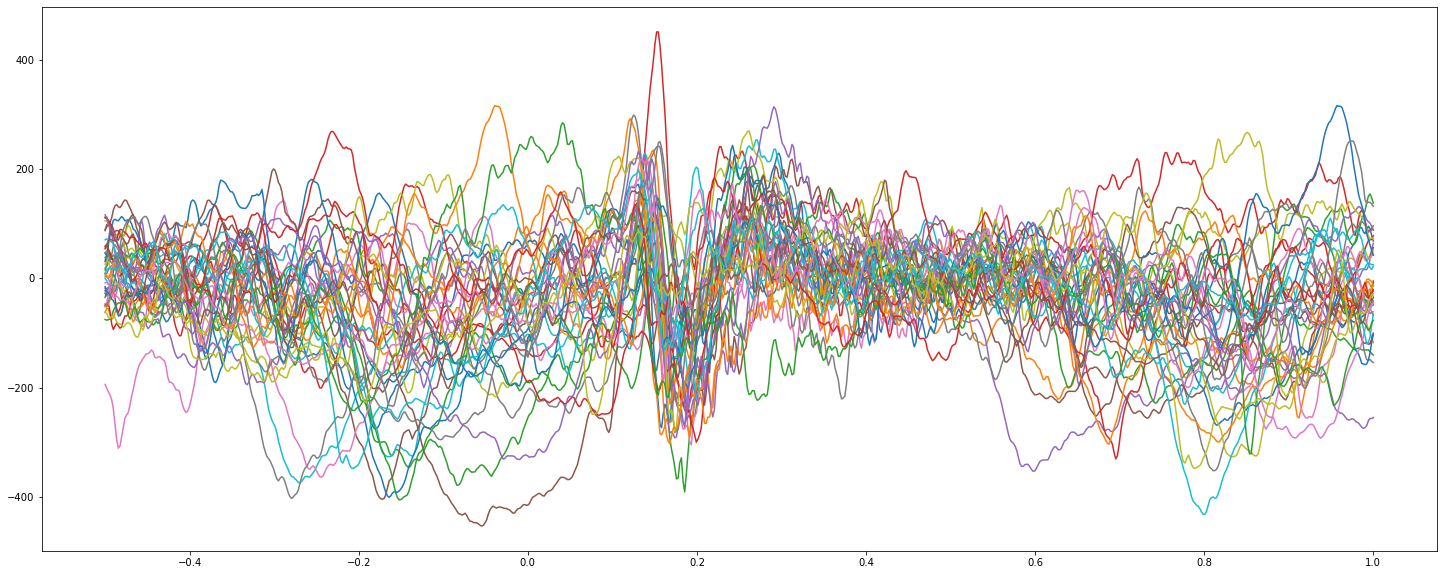

In [201]:
plot_trails(separate_signals,time)

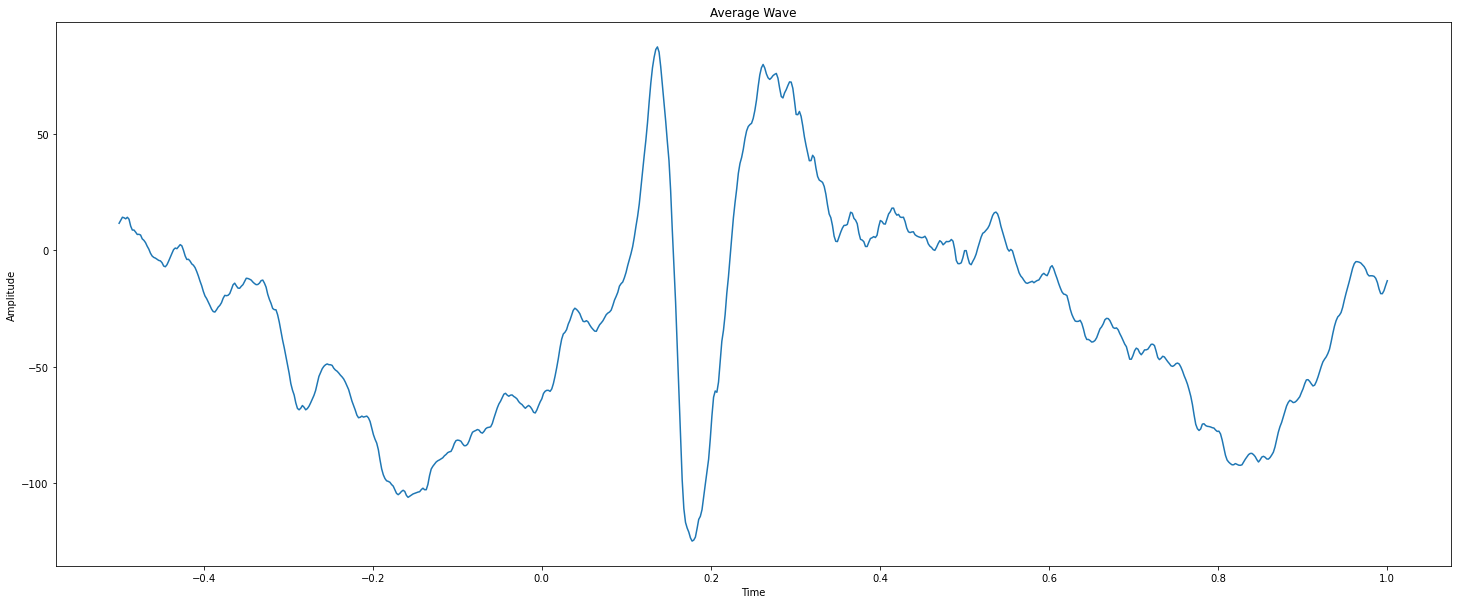

In [202]:
# plotting average wave
avg_wave = avg_trial(separate_signals)
plt.figure(figsize=(25,10))
plt.plot(time, avg_wave)
plt.title("Average Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


2009.3791936250834


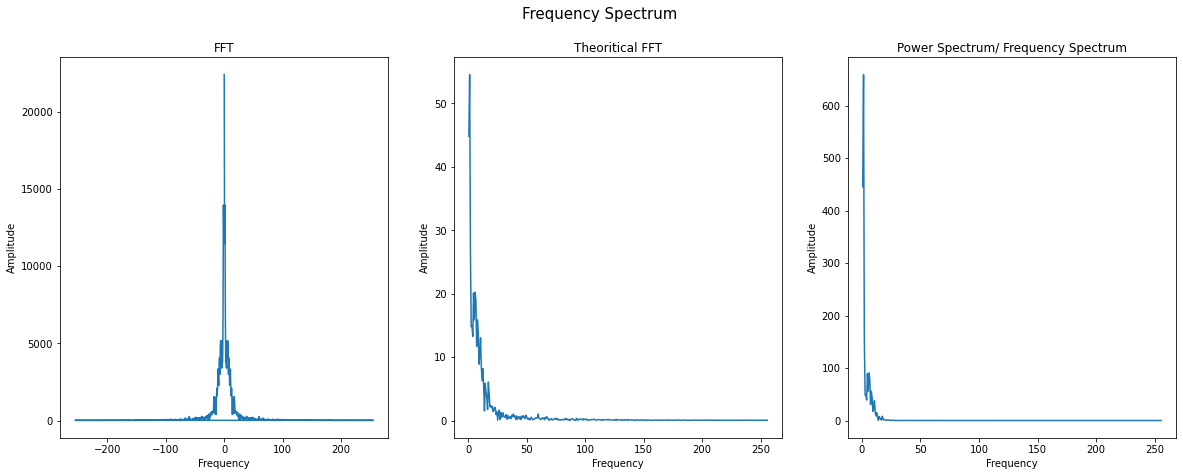

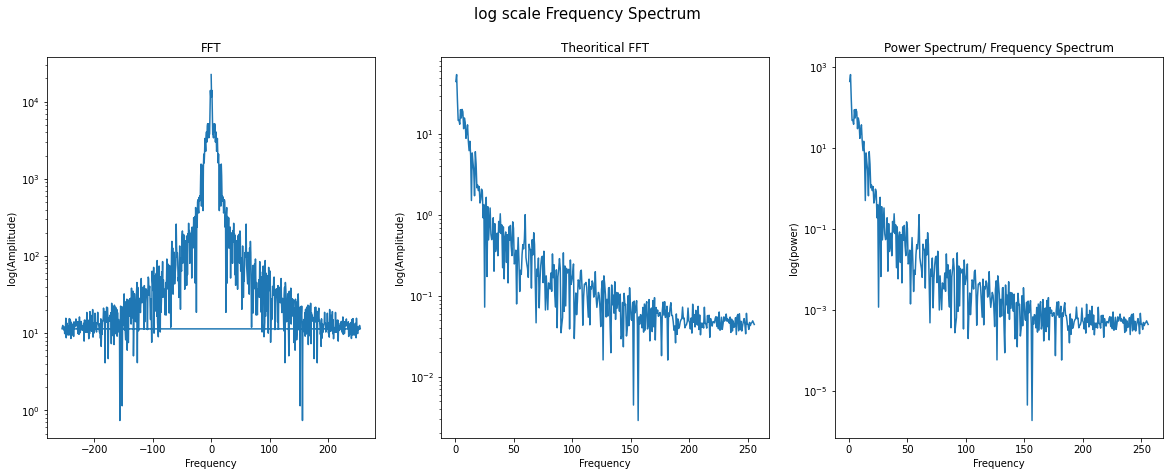

In [203]:
freqs,fft_vals,pos,fft_theo,ps = compute_spectra(avg_wave,fs,time)
plot_spectra(freqs,fft_vals,pos,fft_theo,ps)
logscale_spectrum_plot(freqs,fft_vals,pos,fft_theo,ps)

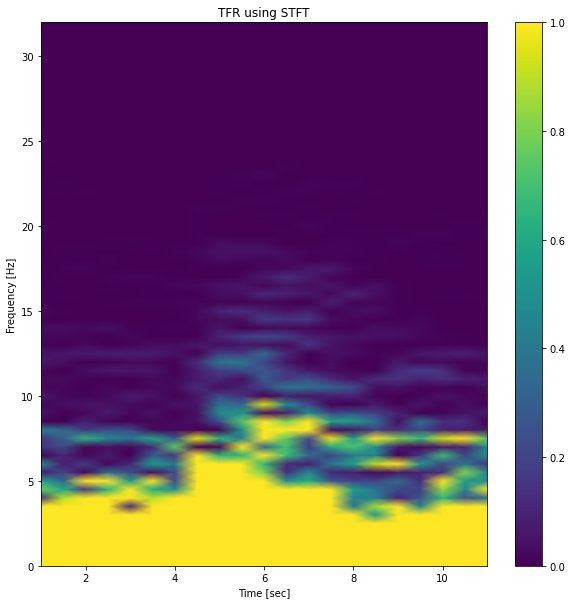

In [204]:
freqs, times, power = stft(avg_wave,fs)
plot_stft(freqs, times, power)

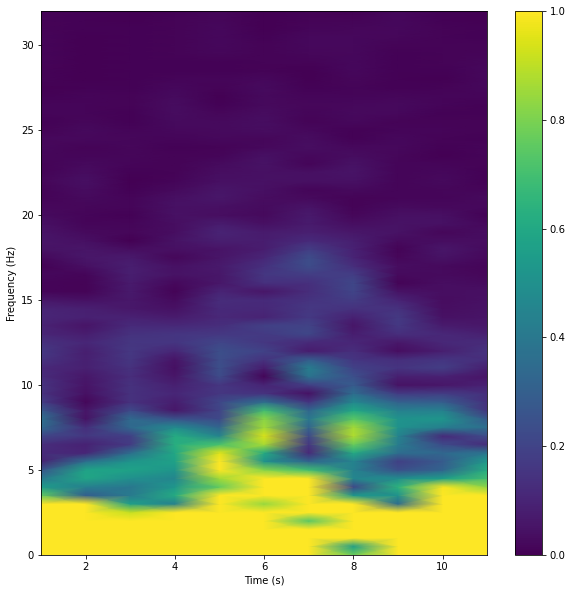

In [205]:
freqs, times, power = multitaper_transform(avg_wave,fs)
plot_multitaper(times, freqs, power)

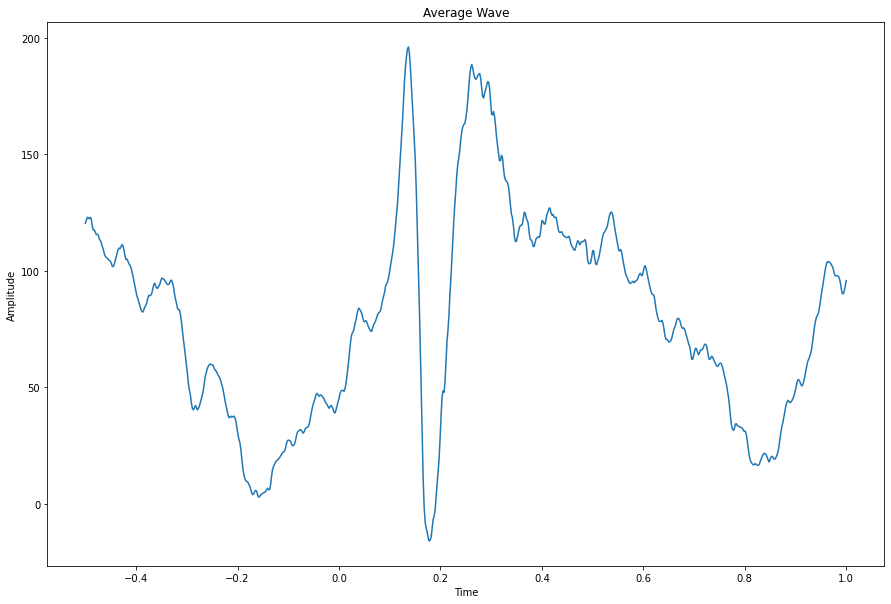

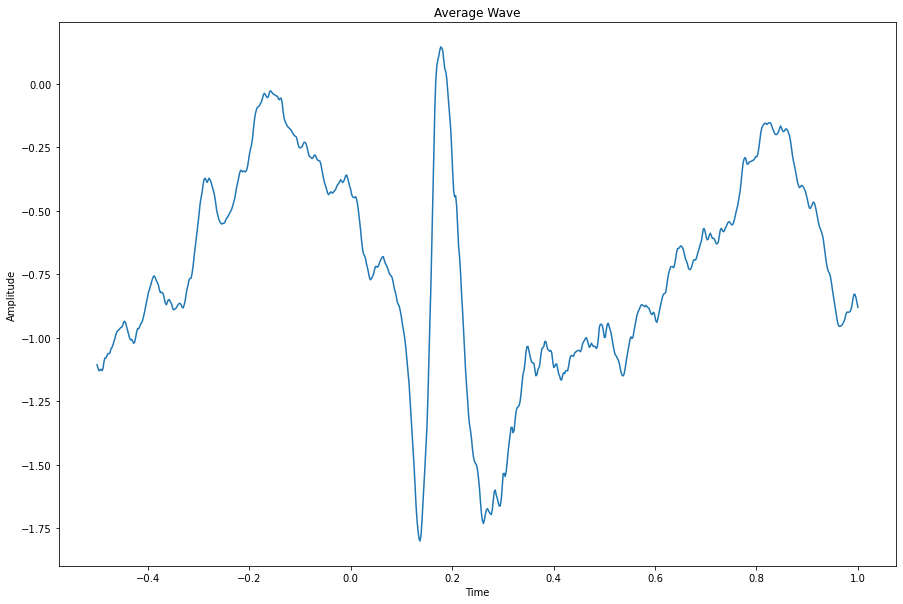

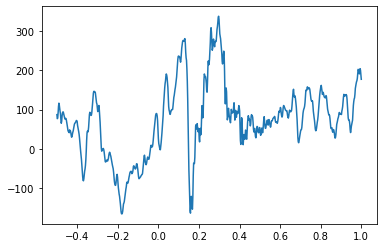

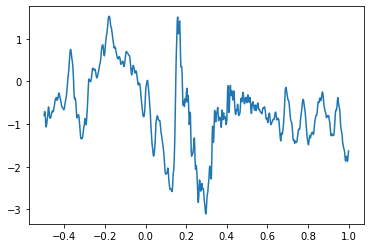

In [206]:
interval = [0,256]
separate_signals_normalized_absolute = baseline_correction_absolute(separate_signals,interval)
#plot_trails(separate_signals_normalized_absolute,time)
avg_epoch = avg_trial(separate_signals_normalized_absolute)
plt.figure(figsize=(15,10))
plt.plot(time, avg_epoch)
plt.title("Average Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

separate_signals_normalized_rc = baseline_correction_relative_change(separate_signals,interval)
#plot_trails(separate_signals_normalized_rc,time)
avg_epoch_rc = avg_trial(separate_signals_normalized_rc)
plt.figure(figsize=(15,10))
plt.plot(time, avg_epoch_rc)
plt.title("Average Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

plt.plot(time, separate_signals_normalized_absolute[0])
plt.show()
plt.plot(time, separate_signals_normalized_rc[0])
plt.show()

8809.123046802022
0.7441574993840071


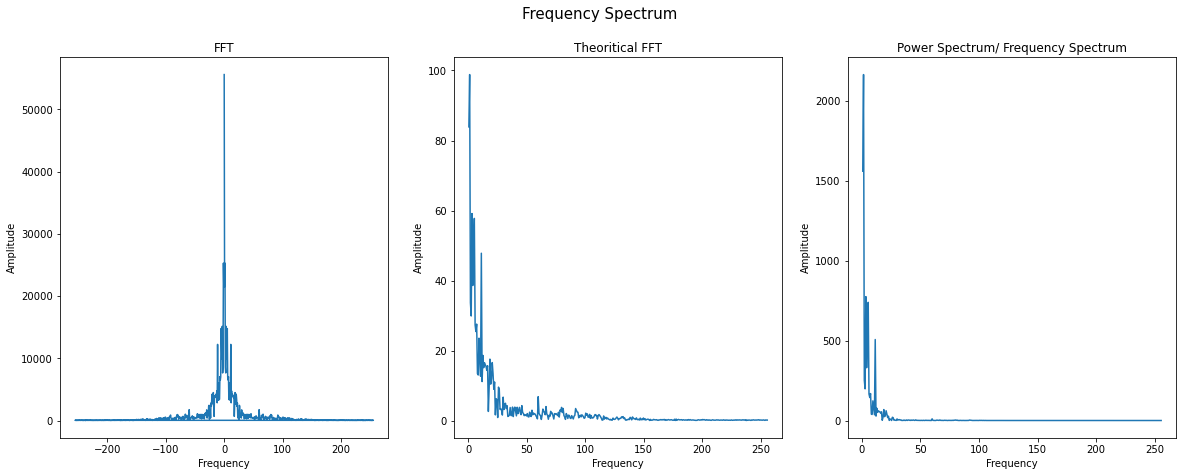

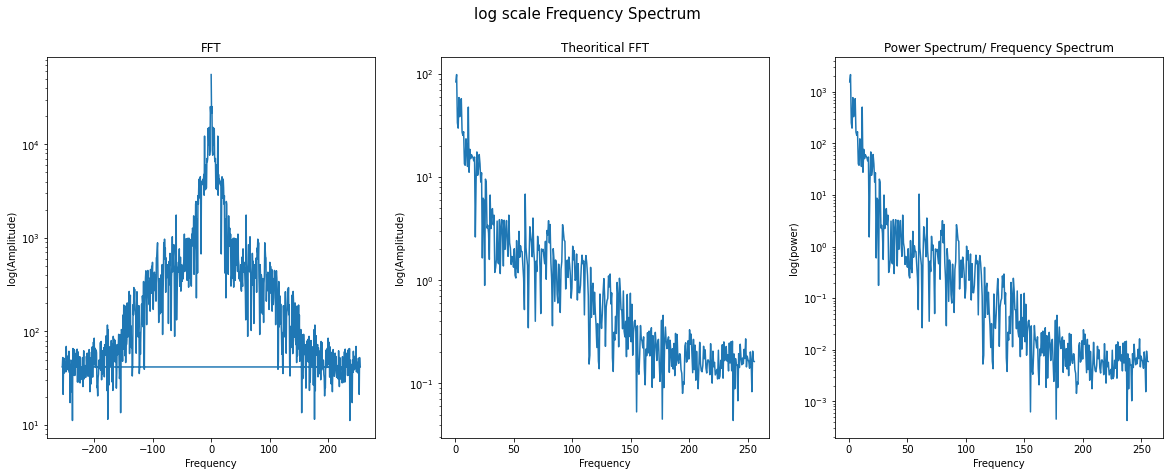

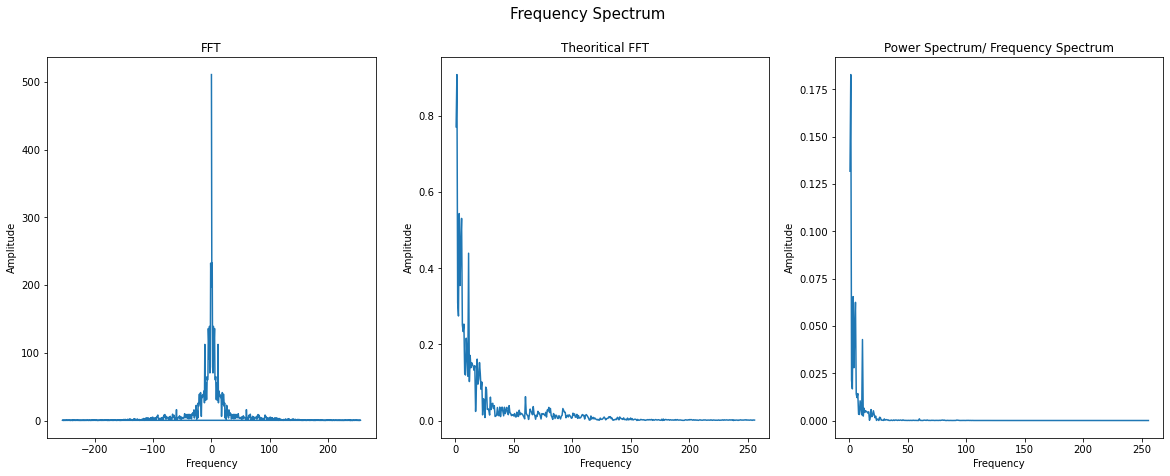

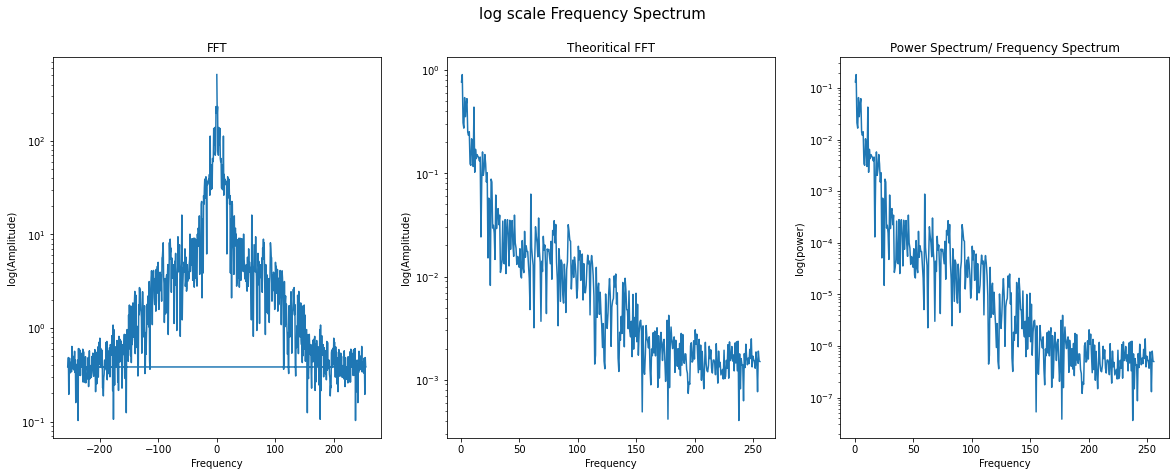

In [207]:
freqs,fft_vals,pos,fft_theo,ps = compute_spectra(separate_signals_normalized_absolute[0],fs,time)
plot_spectra(freqs,fft_vals,pos,fft_theo,ps)
logscale_spectrum_plot(freqs,fft_vals,pos,fft_theo,ps)
freqs,fft_vals,pos,fft_theo,ps = compute_spectra(separate_signals_normalized_rc[0],fs,time)
plot_spectra(freqs,fft_vals,pos,fft_theo,ps)
logscale_spectrum_plot(freqs,fft_vals,pos,fft_theo,ps)

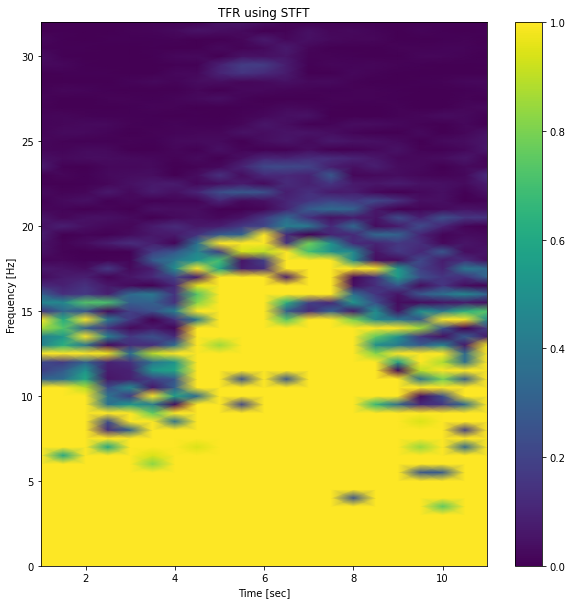

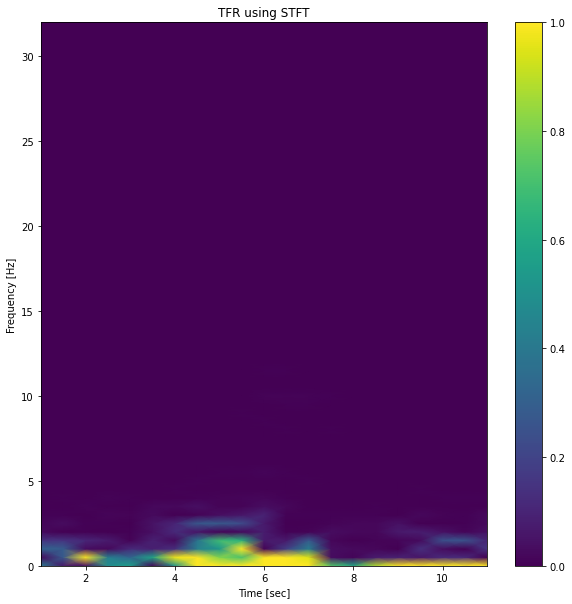

In [208]:
freqs, times, power = stft(separate_signals_normalized_absolute[0],fs)
plot_stft(freqs, times, power)
freqs, times, power = stft(separate_signals_normalized_rc[0],fs)
plot_stft(freqs, times, power)

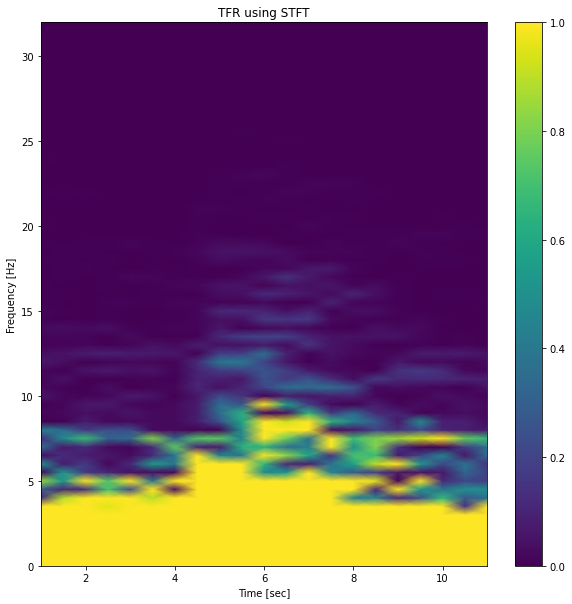

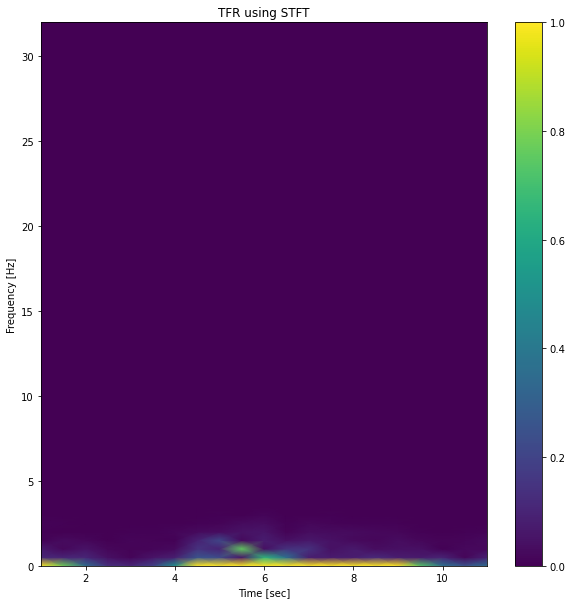

In [209]:
freqs, times, power = stft(avg_epoch,fs)
plot_stft(freqs, times, power)
freqs, times, power = stft(avg_epoch_rc,fs)
plot_stft(freqs, times, power)

## Condition2.mat dataset

In [210]:
mat_contents2 = sio.loadmat('Condition2.mat')
mat2 = mat_contents2['final_mat_condition7']
# print(type(mat_contents2)) 
# mat_contents2.items()
mat2.shape

(40, 769)

In [211]:
# separating trials
separate_signals2 = []
for i in range(0,mat2.shape[0]):
    separate_signals2.append(mat2[i,:])

In [212]:
fs = 512 # sampling frequency
end = 1  # end time
start = -0.5 # start time
time = np.arange(start,end+1/fs, step=1/fs)

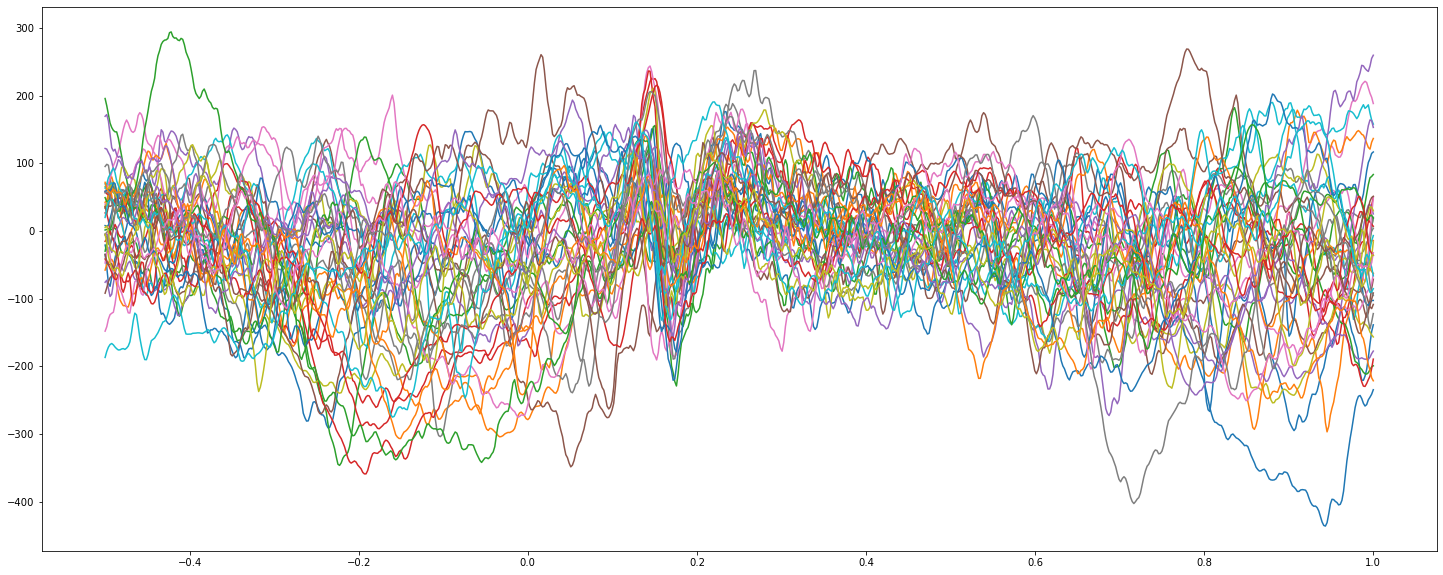

In [213]:
plot_trails(separate_signals2,time)

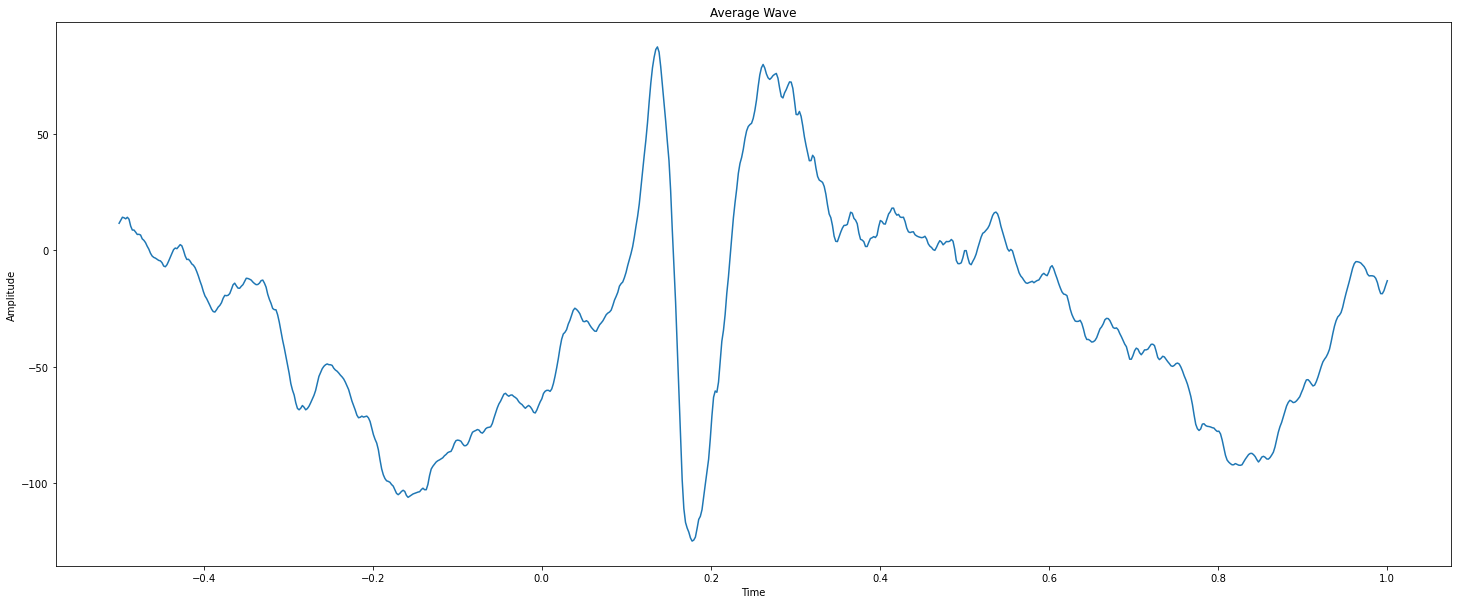

In [214]:
avg_wave2 = avg_trial(separate_signals2)
plt.figure(figsize=(25,10))
plt.plot(time, avg_wave)
plt.title("Average Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

1273.4995622362055


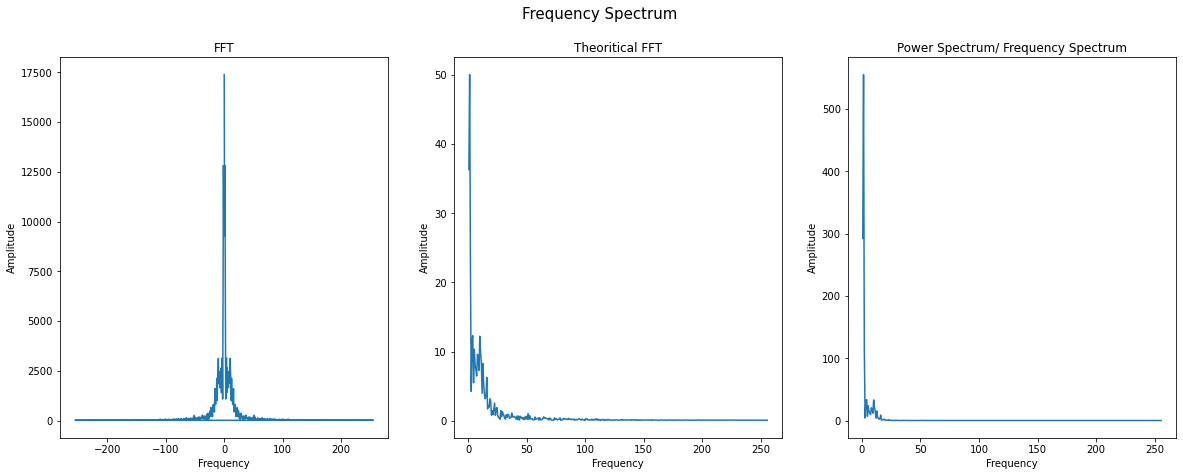

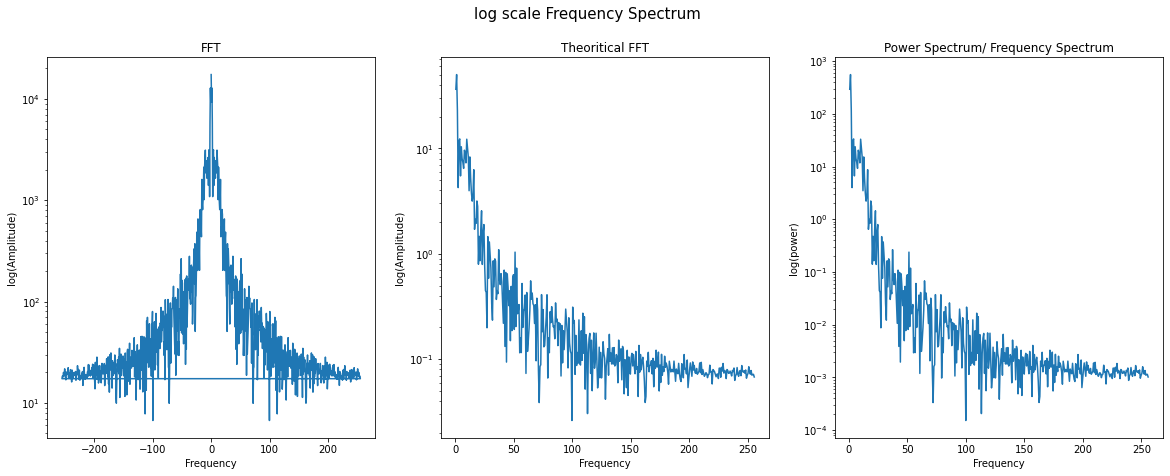

In [215]:
freqs,fft_vals,pos,fft_theo,ps = compute_spectra(avg_wave2,fs,time)
plot_spectra(freqs,fft_vals,pos,fft_theo,ps)
logscale_spectrum_plot(freqs,fft_vals,pos,fft_theo,ps)

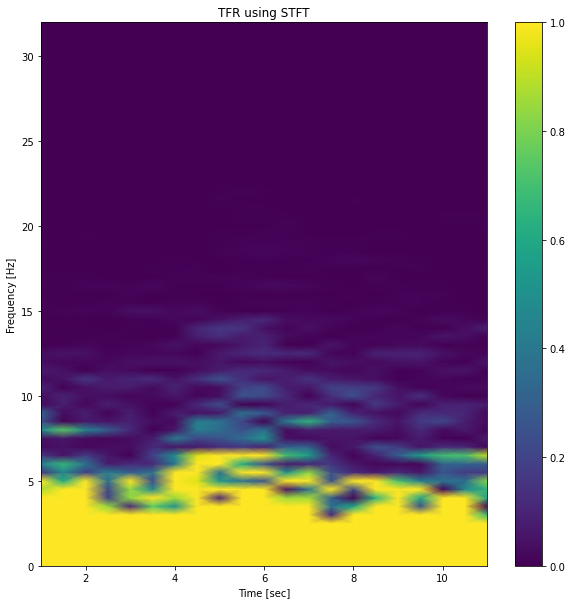

In [216]:
freqs, times, power = stft(avg_wave2,fs)
plot_stft(freqs, times, power)

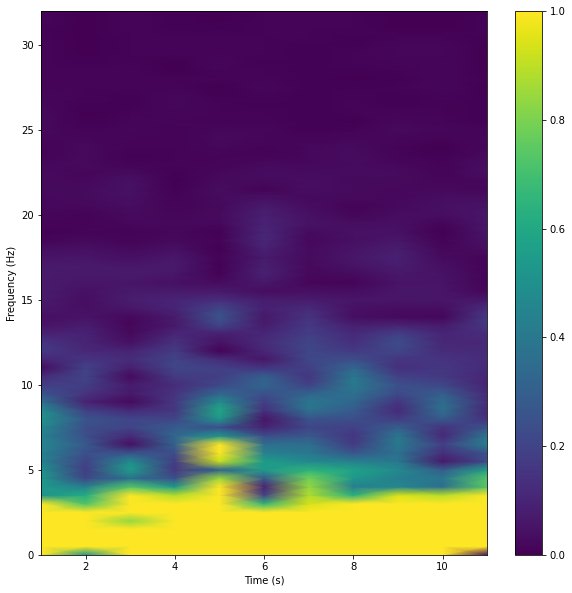

In [217]:
freqs, times, power = multitaper_transform(avg_wave2,fs)
plot_multitaper(times, freqs, power)

### What are the various parameters that need to be assigned? How does the TFR vary with different parameters & why?


### Are you able to visualize the 1/f structure of the noise floor in the TFR? Explain. 
We can see in the TFR that for higher frequencies the power decreases and for lower frequencies the power increases, this shows the 1/f structure of noise floor in TFR

# Normalization of TFR 

### Use two modes to normalize the TFRs (absolute, relative, relative change). Do you find any differences? Explain the outcomes.

### Why do you need to perform normalization? Explain with figures front the data.

# Functional meaning

### Are there any differences between conditions that can be visually observed from the TFR or evoked potential plots?

### Can you propose a strategy to extract summary values and statistics on them?


### What functional meaning of the differences?
